In [164]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import scipy

import matplotlib.pyplot as plt

from sklearn.base import BaseEstimator, TransformerMixin

# Helper functions

In [2]:
def print_long_string(string, indent=0, max_words_per_line=10):
    """
    :param string: str
    :param indent: int
    :param max_words_per_line: int
    :return: None
    """
    words = [" "*indent]
    for i, word in enumerate(string.split()):
        words.append(word)
        if (i+1) % max_words_per_line == 0:
            words.append("\n" + " "*indent)
    print(" ".join(words))
    return None


def print_col_desc(df, table_name, col_desc_df):
    """
    To print out the information of columns of df. This information is taken from col_desc_df
    :param df: dataframe
    :param table_name: str
    :param col_desc_table:
    :return: None
    """
    nrows = df.shape[0]
    all_cols = df.columns.to_list()
    cat_cols = df.select_dtypes(["category", "object", "bool"]).columns.to_list()
    num_cols = [col for col in all_cols if col not in cat_cols]

    for i, col in enumerate(df.columns):
        mask = (col_desc_df["Table"] == table_name) & (col_desc_df["Row"] == col)
        print("Column Number:", i)
        print("Column Name:", col)
        print("Description:")

        if len(col_desc_df.loc[mask, :]) == 0:
            print(" " * 10 + "No Description, Maybe the column name does not match.")
        else:
            print_long_string(col_desc_df.loc[mask, "Description"].iloc[0], indent=10)
            print("Special:", col_desc_df.loc[mask, "Special"].iloc[0])

        print("Type:", df[col].dtype)
        n_null = np.sum(df[col].isnull())
        print("Number of rows:", nrows)
        print("Number of NULL(s):", n_null)
        print("Percent of NULL(s): %.2f%%" % (n_null / nrows * 100))

        nunique = df[col].nunique(dropna=False)
        print("Number of Unique Values:", nunique)
        if nunique <= 20:
            print_long_string(", ".join([str(s) for s in df[col].unique()]),
                                indent=28, max_words_per_line=5)
        else:
            print_long_string(", ".join([str(s) for s in df[col].unique()[:20]]) + " ...",
                                indent=28, max_words_per_line=5)

        if col in num_cols:
            print("Min:", df[col].min())
            print("Max:", df[col].max())
        else:
            print("Mode: ", df[col].mode().values)

        print("-" * 50 + "\n")
    return None


def change_dtypes(df):
    """
    change types of columns to reduce memory size
    :param df: dataframe
    :return df: dataframe
    """
    memory = df.memory_usage().sum() / 10**6
    print("Memory usage before changing types %0.2f MB" % memory)

    for col in df.columns:
        if (df[col].dtype == "object") and (df[col].nunique() < df.shape[0]):
            df[col] = df[col].astype("category")

        elif set(df[col].unique()) == set([0, 1]):
            df[col] = df[col].astype(bool)

        elif df[col].dtype == float:
            df[col] = df[col].astype(np.float32)

        elif df[col].dtype == int:
            df[col] = df[col].astype(np.int32)

    memory = df.memory_usage().sum() / 10 ** 6
    print("Memory usage after changing types %0.2f MB" % memory)
    return df

In [85]:
def weighted_variance(x, weights):
    average = np.average(x, weights=weights)
    variance = np.average((x - average)**2, weights=weights)
    return variance


def between_group_variance(group_averages, weights):
    return weighted_variance(group_averages, weights=weights)


def within_group_variance(group_variances, weights):
    return np.average(group_variances, weights=weights)


def f_ratio(group_averages, group_variances, weights):
    return between_group_variance(group_averages, weights) / within_group_variance(group_variances, weights)


def corrwith(df, series):
    """
    :param df: a dataframe
    :param series: a series
    :return: corrs, a series
    """
    corrs = df.corrwith(series)
    corrs = corrs.reset_index()
    corrs.columns = ["feature", "corr"]

    corrs["abs_corr"] = np.abs(corrs["corr"])
    corrs = corrs.sort_values("abs_corr", ascending=False)
    corrs = corrs.set_index("feature")

    corrs = corrs.drop(["abs_corr"], axis=1)

    return corrs["corr"]


def mode(ser):
    return ser.mode().values[0]


def mean_diff(x):
    return x.sort_values().diff().mean()


def var_diff(x):
    return x.sort_values().diff().var()


def range_diff(x):
    diff = x.sort_values().diff()
    return diff.max() - diff.min()

In [4]:
def f_ratio_df(df):
    return f_ratio(df["default_rate"], df["var_of_default_rate"], df["count"])

In [81]:
def flatten_multiindex_cols(columns):
    fat_cols = ["_".join([str(c) for c in flat_col]) for flat_col in columns.to_flat_index()]
    return fat_cols


def agg_num_cols(df, by_sers, stats):
    assert type(by_sers) in [list, tuple], "by_sers must be a list or tuple"
    assert type(stats) in [list, tuple], "stats must be a list or tuple"
    
    for ser in by_sers:
        assert isinstance(ser, pd.Series), "ser in by_sers must be Series"
        
    cat_cols = df.select_dtypes(["object", "bool", "category"]).columns.to_list()
    if len(cat_cols) > 0:
        raise ValueError("There are non-number cols: " + ", ".join(cat_cols))
    
    df_agg = df.groupby(by_sers).agg(stats)
    df_agg.columns = flatten_multiindex_cols(df_agg.columns)
    df_agg = df_agg.reset_index()
    
    return df_agg


def agg_cat_cols(df, by_sers, stats):
    assert type(by_sers) in [list, tuple], "by_sers must be a list or tuple"
    assert type(stats) in [list, tuple], "stats must be a list or tuple"
    
    for ser in by_sers:
        assert isinstance(ser, pd.Series), "ser in by_sers must be Series"
        
    num_cols = df.select_dtypes(["number"]).columns.to_list()
    if len(num_cols) > 0:
        raise ValueError("There are number cols: " + ", ".join(num_cols))
    
    df_agg = df.groupby(by_sers).agg(stats)
    df_agg.columns = flatten_multiindex_cols(df_agg.columns)
    df_agg = df_agg.reset_index()
    
    return df_agg

In [240]:
def check_type(val):
    if type(val) == str:
        return "string"
    
    if np.issubsctype(type(val), np.number):
        return "number"
    
    if callable(val):
        return "function"
    
    return str(type(val))


class NumColsImputer(BaseEstimator, TransformerMixin):
    def __init__(self, default="median", specified_values=None):
        assert (specified_values is None) or isinstance(specified_values, 
                                                        dict), "specified_values must be None or dict"
        
        self._specified_values = specified_values
        if self._specified_values is not None:
            for col, val in self._specified_values.items():
                assert check_type(val) == "number", "Impute value for " + col + " is not number."
        
        self._default = default
        self._default_type = check_type(self._default)
        if self._default_type not in ["number", "string", "function"]:
            raise ValueError("Unsupported stat type " + self._default_type)
    
    def _cal_imput_vals(self, df):
        cat_cols = df.select_dtypes(["object", "category", "bool"]).columns.to_list()
        if len(cat_cols) > 0:
            raise ValueError("There are non-number columns: " + ", ".join(cat_cols))
        
        all_cols = df.columns.to_list()
        if self._default_type == "number":
            impute_values = {col: self._default for col in all_cols}
            
        elif self._default_type == "string":
            impute_values = getattr(df, self._default)()
        
        elif self._default_type == "function":
            impute_values = df.apply(self._default)
        
        else:
            return None
            
        impute_values = dict(impute_values)
        if self._specified_values is None:
            return impute_values
        
        for col in self._specified_values:
            impute_values[col] = self._specified_values[col]
            
        return impute_values
    
    def fit(self, df):
        impute_values = self._cal_imput_vals(df)
        
        cols_with_na = [col for col in df.columns if df[col].isnull().any()]
        self._impute_values = {col: impute_values[col] for col in cols_with_na}
        
        for k, v in self._impute_values.items():
            if np.isnan(v):
                raise ValueError("One of the impute_values is NaN: " + k)
        
        return self
    
    def transform(self, df):
        return df.fillna(self._impute_values)

In [241]:
application_num = application_train.select_dtypes(["number"])

imputer = NumColsImputer(default="median", specified_values={"AMT_INCOME_TOTAL": 10, "DAYS_EMPLOYED": 100})
imputer.fit(application_num)
application_imput = imputer.transform(application_num)

In [242]:
application_imput.isnull().sum().sum()

0

In [244]:
application_num.isnull().sum().sum()

8388094

# Understanding columns of dataframes

In [5]:
col_desc = pd.read_csv("data/download/HomeCredit_columns_description.csv", encoding="ISO-8859-1")

## `application_train.csv`

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).

Static data for all applications. One row represents one loan in our data sample.

In [6]:
application_train = pd.read_csv("data/download/application_train.csv")
application_train = change_dtypes(application_train)
print("application_train.shape:", application_train.shape)
application_train.head()

Memory usage before changing types 300.13 MB
Memory usage after changing types 104.87 MB
application_train.shape: (307511, 122)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,True,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,False,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,False,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,False,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,False,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
application_train.shape

(307511, 122)

In [8]:
application_train.dtypes

SK_ID_CURR                       int32
TARGET                            bool
NAME_CONTRACT_TYPE            category
CODE_GENDER                   category
FLAG_OWN_CAR                  category
                                ...   
AMT_REQ_CREDIT_BUREAU_DAY      float32
AMT_REQ_CREDIT_BUREAU_WEEK     float32
AMT_REQ_CREDIT_BUREAU_MON      float32
AMT_REQ_CREDIT_BUREAU_QRT      float32
AMT_REQ_CREDIT_BUREAU_YEAR     float32
Length: 122, dtype: object

In [9]:
application_train["SK_ID_CURR"].is_unique

True

In [10]:
print_col_desc(application_train, "application_{train|test}.csv", col_desc)

Column Number: 0
Column Name: SK_ID_CURR
Description:
           ID of loan in our sample
Special: nan
Type: int32
Number of rows: 307511
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 307511
                             100002, 100003, 100004, 100006, 100007, 
                             100008, 100009, 100010, 100011, 100012, 
                             100014, 100015, 100016, 100017, 100018, 
                             100019, 100020, 100021, 100022, 100023 
                             ...
Min: 100002
Max: 456255
--------------------------------------------------

Column Number: 1
Column Name: TARGET
Description:
           Target variable (1 - client with payment difficulties: he/she had 
           late payment more than X days on at least one 
           of the first Y installments of the loan in our 
           sample, 0 - all other cases)
Special: nan
Type: bool
Number of rows: 307511
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique

Min: 1
Max: 3
--------------------------------------------------

Column Number: 32
Column Name: WEEKDAY_APPR_PROCESS_START
Description:
           On which day of the week did the client apply 
           for the loan
Special: nan
Type: category
Number of rows: 307511
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 7
                             WEDNESDAY, MONDAY, THURSDAY, SUNDAY, SATURDAY, 
                             FRIDAY, TUESDAY
Mode:  ['TUESDAY']
Categories (7, object): ['FRIDAY', 'MONDAY', 'SATURDAY', 'SUNDAY', 'THURSDAY', 'TUESDAY', 'WEDNESDAY']
--------------------------------------------------

Column Number: 33
Column Name: HOUR_APPR_PROCESS_START
Description:
           Approximately at what hour did the client apply for the 
           loan
Special: rounded
Type: int32
Number of rows: 307511
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 24
                             10, 11, 9, 17, 16, 
                             14,

Number of rows: 307511
Number of NULL(s): 214865
Percent of NULL(s): 69.87%
Number of Unique Values: 3182
                             0.0143, 0.0605, nan, 0.0582, 0.1143, 
                             0.0018, 0.012, 0.1064, 0.0212, 0.001, 
                             0.0188, 0.0056, 0.0142, 0.0822, 0.0528, 
                             0.0385, 0.0029, 0.0076, 0.0096, 0.013 
                             ...
Min: 0.0
Max: 1.0
--------------------------------------------------

Column Number: 49
Column Name: ELEVATORS_AVG
Description:
           Normalized information about building where the client lives, What is 
           average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment 
           size, common area, living area, age of building, number of 
           elevators, number of entrances, state of the building, number of 
           floor
Special: normalized
Type: float32
Number of rows: 307511
Number of NULL(s): 163891
Percent of NULL(s): 53.30%
Number of Uniq

                             0.9722, 0.9851, nan, 0.9811, 0.9806, 
                             0.9985, 0.9881, 0.9782, 0.9786, 0.9876, 
                             0.9861, 0.9732, 0.9831, 0.9697, 0.9901, 
                             0.9801, 0.9762, 0.996, 0.998, 0.9846 
                             ...
Min: 0.0
Max: 1.0
--------------------------------------------------

Column Number: 61
Column Name: YEARS_BUILD_MODE
Description:
           Normalized information about building where the client lives, What is 
           average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment 
           size, common area, living area, age of building, number of 
           elevators, number of entrances, state of the building, number of 
           floor
Special: normalized
Type: float32
Number of rows: 307511
Number of NULL(s): 204488
Percent of NULL(s): 66.50%
Number of Unique Values: 155
                             0.6341, 0.804, nan, 0.7452, 0.9804, 
                     

Number of Unique Values: 3773
                             0.0369, 0.0529, nan, 0.0973, 0.1335, 
                             0.0617, 0.0801, 0.0795, 0.0848, 0.1455, 
                             0.0147, 0.0089, 0.0838, 0.3751, 0.0804, 
                             0.0792, 0.0994, 0.125, 0.1232, 0.0408 
                             ...
Min: 0.0
Max: 1.0
--------------------------------------------------

Column Number: 74
Column Name: YEARS_BEGINEXPLUATATION_MEDI
Description:
           Normalized information about building where the client lives, What is 
           average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment 
           size, common area, living area, age of building, number of 
           elevators, number of entrances, state of the building, number of 
           floor
Special: normalized
Type: float32
Number of rows: 307511
Number of NULL(s): 150007
Percent of NULL(s): 48.78%
Number of Unique Values: 246
                             0.9722, 0.9851,

Special: normalized
Type: category
Number of rows: 307511
Number of NULL(s): 210295
Percent of NULL(s): 68.39%
Number of Unique Values: 5
                             reg oper account, nan, org 
                             spec account, reg oper spec 
                             account, not specified
Mode:  ['reg oper account']
Categories (4, object): ['not specified', 'org spec account', 'reg oper account', 'reg oper spec account']
--------------------------------------------------

Column Number: 87
Column Name: HOUSETYPE_MODE
Description:
           Normalized information about building where the client lives, What is 
           average (_AVG suffix), modus (_MODE suffix), median (_MEDI suffix) apartment 
           size, common area, living area, age of building, number of 
           elevators, number of entrances, state of the building, number of 
           floor
Special: normalized
Type: category
Number of rows: 307511
Number of NULL(s): 154297
Percent of NULL(s): 50.18%
Nu

Special: nan
Type: bool
Number of rows: 307511
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 2
                             False, True
Mode:  [False]
--------------------------------------------------

Column Number: 104
Column Name: FLAG_DOCUMENT_10
Description:
           Did client provide document 10
Special: nan
Type: bool
Number of rows: 307511
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 2
                             False, True
Mode:  [False]
--------------------------------------------------

Column Number: 105
Column Name: FLAG_DOCUMENT_11
Description:
           Did client provide document 11
Special: nan
Type: bool
Number of rows: 307511
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 2
                             False, True
Mode:  [False]
--------------------------------------------------

Column Number: 106
Column Name: FLAG_DOCUMENT_12
Description:
           Did client provide document 12
S

In [11]:
application_test = pd.read_csv("data/download/application_test.csv")
application_test = change_dtypes(application_test)

Memory usage before changing types 47.18 MB
Memory usage after changing types 18.19 MB


In [12]:
nrows_train_test = application_train.shape[0] + application_test.shape[0]
nrows_train_test

356255

## `bureau.csv`

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).

For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

In [13]:
bureau = pd.read_csv("data/download/bureau.csv")
bureau = change_dtypes(bureau)
print("bureau.shape:", bureau.shape)
bureau.head()

Memory usage before changing types 233.43 MB
Memory usage after changing types 101.27 MB
bureau.shape: (1716428, 17)


,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


In [14]:
bureau["SK_ID_CURR"].is_unique

False

In [15]:
bureau["SK_ID_CURR"].nunique()

305811

In [16]:
# there are about 24% of applications do not have bureau data
bureau["SK_ID_CURR"].nunique() / nrows_train_test

0.8584047943186762

In [17]:
bureau["SK_ID_BUREAU"].is_unique

True

In [18]:
print_col_desc(bureau, "bureau.csv", col_desc)

Column Number: 0
Column Name: SK_ID_CURR
Description:
           ID of loan in our sample - one loan in 
           our sample can have 0,1,2 or more related previous credits 
           in credit bureau
Special: hashed
Type: int32
Number of rows: 1716428
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 305811
                             215354, 162297, 402440, 238881, 222183, 
                             426155, 136226, 400486, 435112, 452585, 
                             389599, 242993, 303740, 234931, 311918, 
                             119939, 388421, 419892, 387080, 293201 
                             ...
Min: 100001
Max: 456255
--------------------------------------------------

Column Number: 1
Column Name: SK_ID_BUREAU
Description:
          No Description, Maybe the column name does not match.
Type: int32
Number of rows: 1716428
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 1716428
                             5714462, 571

Special: time only relative to the application
Type: int32
Number of rows: 1716428
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 2982
                             -131, -20, -16, -21, -31, 
                             -22, -1710, -840, -690, -706, 
                             -185, -2601, -984, -4, -7, 
                             -71, -694, -210, -24, -2559 
                             ...
Min: -41947
Max: 372
--------------------------------------------------

Column Number: 16
Column Name: AMT_ANNUITY
Description:
           Annuity of the Credit Bureau credit
Special: nan
Type: float32
Number of rows: 1716428
Number of NULL(s): 1226791
Percent of NULL(s): 71.47%
Number of Unique Values: 40322
                             nan, 0.0, 2691.0, 24462.0, 8181.0, 
                             8061.21, 13131.0, 40522.004, 26550.0, 67995.0, 
                             43668.0, 15321.87, 10491.885, 27000.0, 8245.395, 
                             12162.15, 3337

## `bureau_balance.csv`

Monthly balances of previous credits in Credit Bureau.

This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

In [19]:
bureau_balance = pd.read_csv("data/download/bureau_balance.csv")
print("bureau_balance.shape:", bureau_balance.shape)
bureau_balance.head()

bureau_balance.shape: (27299925, 3)


,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C


In [20]:
bureau_balance["SK_ID_BUREAU"].is_unique

False

In [21]:
# only half of the applications in bureau have month records in bureau_balance
bureau_balance["SK_ID_BUREAU"].nunique() / bureau.shape[0]

0.4762186354452386

In [22]:
print_col_desc(bureau_balance, "bureau_balance.csv", col_desc)

Column Number: 0
Column Name: SK_ID_BUREAU
Description:
          No Description, Maybe the column name does not match.
Type: int64
Number of rows: 27299925
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 817395
                             5715448, 5715449, 5715451, 5715452, 5715453, 
                             5715454, 5715455, 5715456, 5715457, 5715458, 
                             5715459, 5715460, 5715461, 5715478, 5715479, 
                             5715480, 5715521, 5715529, 5715530, 5715531 
                             ...
Min: 5001709
Max: 6842888
--------------------------------------------------

Column Number: 1
Column Name: MONTHS_BALANCE
Description:
           Month of balance relative to application date (-1 means the 
           freshest balance date)
Special: time only relative to the application
Type: int64
Number of rows: 27299925
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 97
                             0,

## `previous_application.csv`

All previous applications for Home Credit loans of clients who have loans in our sample.

There is one row for each previous application related to loans in our data sample.

In [23]:
previous_application = pd.read_csv("data/download/previous_application.csv")
previous_application = change_dtypes(previous_application)
print("previous_application.shape:", previous_application.shape)
previous_application.head()

Memory usage before changing types 494.38 MB
Memory usage after changing types 162.02 MB
previous_application.shape: (1670214, 37)


,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [24]:
previous_application["SK_ID_PREV"].is_unique

True

In [25]:
previous_application["SK_ID_CURR"].is_unique

False

In [26]:
# about 5% of current applications are compleltely new, having no previous applications at Home Credit.
previous_application["SK_ID_CURR"].nunique() / nrows_train_test

0.9511641941867482

In [27]:
print_col_desc(previous_application, "previous_application.csv", col_desc)

Column Number: 0
Column Name: SK_ID_PREV
Description:
          No Description, Maybe the column name does not match.
Type: int32
Number of rows: 1670214
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 1670214
                             2030495, 2802425, 2523466, 2819243, 1784265, 
                             1383531, 2315218, 1656711, 2367563, 2579447, 
                             1715995, 2257824, 2330894, 1397919, 2273188, 
                             1232483, 2163253, 1285768, 2393109, 1173070 
                             ...
Min: 1000001
Max: 2845382
--------------------------------------------------

Column Number: 1
Column Name: SK_ID_CURR
Description:
           ID of loan in our sample
Special: hashed
Type: int32
Number of rows: 1670214
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 338857
                             271877, 108129, 122040, 176158, 202054, 
                             199383, 175704, 296299, 342292, 3343

Number of Unique Values: 25
                             XAP, XNA, Repairs, Everyday expenses, 
                             Car repairs, Building a house 
                             or an annex, Other, Journey, 
                             Purchase of electronic equipment, Medicine, 
                             Payments on other loans, Urgent 
                             needs, Buying a used car, 
                             Buying a new car, Buying 
                             a holiday home / land, 
                             Education, Buying a home, Furniture, 
                             Buying a garage, Business development 
                             ...
Mode:  ['XAP']
Categories (25, object): ['Building a house or an annex', 'Business development', 'Buying a garage', 'Buying a holiday home / land', ..., 'Urgent needs', 'Wedding / gift / holiday', 'XAP', 'XNA']
--------------------------------------------------

Column Number: 16
Column Name: NAME_CONTRACT_STATUS
De

Min: -2922.0
Max: 365243.0
--------------------------------------------------

Column Number: 32
Column Name: DAYS_FIRST_DUE
Description:
           Relative to application date of current application when was the 
           first due supposed to be of the previous application
Special: time only relative to the application
Type: float32
Number of rows: 1670214
Number of NULL(s): 673065
Percent of NULL(s): 40.30%
Number of Unique Values: 2893
                             -42.0, -134.0, -271.0, -482.0, nan, 
                             -654.0, -705.0, -785.0, -830.0, -378.0, 
                             -693.0, -668.0, -1440.0, -257.0, -656.0, 
                             -340.0, -1457.0, -1853.0, -2671.0, -273.0 
                             ...
Min: -2892.0
Max: 365243.0
--------------------------------------------------

Column Number: 33
Column Name: DAYS_LAST_DUE_1ST_VERSION
Description:
           Relative to application date of current application when was the 
           firs

In [28]:
application_train["NAME_CONTRACT_TYPE"].unique()

['Cash loans', 'Revolving loans']
Categories (2, object): ['Cash loans', 'Revolving loans']

In [29]:
previous_application["NAME_CONTRACT_TYPE"].unique()

['Consumer loans', 'Cash loans', 'Revolving loans', 'XNA']
Categories (4, object): ['Consumer loans', 'Cash loans', 'Revolving loans', 'XNA']

In [30]:
(previous_application["NAME_CONTRACT_TYPE"] == "Consumer loans").mean()

0.4365614226679934

In [31]:
previous_application[previous_application["NAME_CONTRACT_TYPE"] == "Consumer loans"]

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
13,1397919,321676,Consumer loans,7654.859863,53779.5,57564.0,0.0,53779.5,SUNDAY,15,...,Consumer electronics,8.0,low_action,POS household without interest,365243.0,-378.0,-168.0,-168.0,-163.0,1.0
14,2273188,270658,Consumer loans,9644.219727,26550.0,27252.0,0.0,26550.0,SATURDAY,10,...,Consumer electronics,3.0,middle,POS household with interest,365243.0,-693.0,-633.0,-633.0,-627.0,0.0
15,1232483,151612,Consumer loans,21307.455078,126490.5,119853.0,12649.5,126490.5,TUESDAY,7,...,Industry,6.0,low_normal,POS other with interest,365243.0,-668.0,-518.0,-518.0,-512.0,0.0
16,2163253,154602,Consumer loans,4187.339844,26955.0,27297.0,1350.0,26955.0,SATURDAY,12,...,Consumer electronics,8.0,high,POS household with interest,365243.0,-1440.0,-1230.0,-1230.0,-1226.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1670202,2205099,157707,Consumer loans,4334.354980,22207.5,23854.5,0.0,22207.5,THURSDAY,10,...,Clothing,6.0,middle,POS industry with interest,365243.0,-948.0,-798.0,-858.0,-850.0,0.0
1670203,2844282,383898,Consumer loans,NaN,14791.5,14791.5,0.0,14791.5,TUESDAY,13,...,Connectivity,NaN,XNA,POS mobile with interest,NaN,NaN,NaN,NaN,NaN,NaN
1670209,2300464,352015,Consumer loans,14704.290039,267295.5,311400.0,0.0,267295.5,WEDNESDAY,12,...,Furniture,30.0,low_normal,POS industry with interest,365243.0,-508.0,362.0,-358.0,-351.0,0.0
1670210,2357031,334635,Consumer loans,6622.020020,87750.0,64291.5,29250.0,87750.0,TUESDAY,15,...,Furniture,12.0,middle,POS industry with interest,365243.0,-1604.0,-1274.0,-1304.0,-1297.0,0.0


## `POS_CASH_balance.csv`

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.

This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

In [32]:
POS_CASH_balance = pd.read_csv("data/download/POS_CASH_balance.csv")
POS_CASH_balance = change_dtypes(POS_CASH_balance)
print("POS_CASH_balance.shape:", POS_CASH_balance.shape)
POS_CASH_balance.head()

Memory usage before changing types 640.09 MB
Memory usage after changing types 290.04 MB
POS_CASH_balance.shape: (10001358, 8)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0,45.0,Active,0,0
1,1715348,367990,-33,36.0,35.0,Active,0,0
2,1784872,397406,-32,12.0,9.0,Active,0,0
3,1903291,269225,-35,48.0,42.0,Active,0,0
4,2341044,334279,-35,36.0,35.0,Active,0,0


In [33]:
[id_col for id_col in POS_CASH_balance.columns.values if id_col.startswith("SK_ID")]

['SK_ID_PREV', 'SK_ID_CURR']

In [34]:
POS_CASH_balance["SK_ID_PREV"].is_unique

False

In [35]:
POS_CASH_balance["SK_ID_CURR"].is_unique

False

In [36]:
# about 44% of previous applications do not have monthly data in POS_CASH_balance
POS_CASH_balance["SK_ID_PREV"].nunique() / previous_application.shape[0]

0.5606018150967481

In [37]:
POS_CASH_balance.groupby(by=["SK_ID_PREV"])["SK_ID_CURR"].count().head()

SK_ID_PREV
1000001     3
1000002     5
1000003     4
1000004     8
1000005    11
Name: SK_ID_CURR, dtype: int64

In [38]:
tmp = POS_CASH_balance.groupby(by=["SK_ID_PREV"])["SK_ID_CURR"].nunique()
print(tmp.head())

# so each "SK_ID_PREV" is corresponding to a unique "SK_ID_CURR"
tmp[tmp > 1]

SK_ID_PREV
1000001    1
1000002    1
1000003    1
1000004    1
1000005    1
Name: SK_ID_CURR, dtype: int64


Series([], Name: SK_ID_CURR, dtype: int64)

In [39]:
print_col_desc(POS_CASH_balance, "POS_CASH_balance.csv", col_desc)

Column Number: 0
Column Name: SK_ID_PREV
Description:
          No Description, Maybe the column name does not match.
Type: int32
Number of rows: 10001358
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 936325
                             1803195, 1715348, 1784872, 1903291, 2341044, 
                             2207092, 1110516, 1387235, 1220500, 2371489, 
                             2328294, 2023570, 1258390, 1627166, 1711625, 
                             2374177, 1716688, 1846127, 1911764, 2645133 
                             ...
Min: 1000001
Max: 2843499
--------------------------------------------------

Column Number: 1
Column Name: SK_ID_CURR
Description:
           ID of loan in our sample
Special: nan
Type: int32
Number of rows: 10001358
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 337252
                             182943, 367990, 397406, 269225, 334279, 
                             342166, 204376, 153211, 112740, 274851

In [40]:
group = POS_CASH_balance.groupby(["SK_ID_PREV"])
count = 0
for name, df in group:
    print(df[["MONTHS_BALANCE"]].sort_values(by="MONTHS_BALANCE", ascending=False).head())
    count += 1
    if count > 5:
        break

         MONTHS_BALANCE
45995                -8
8470736              -9
6030662             -10
         MONTHS_BALANCE
2792302             -50
2658581             -51
2549591             -52
3346102             -53
4467804             -54
         MONTHS_BALANCE
7085917              -1
9852178              -2
6496374              -3
6584537              -4
         MONTHS_BALANCE
4078063             -22
5534254             -23
4978909             -24
5674882             -25
514734              -26
         MONTHS_BALANCE
7852623             -46
6387329             -47
2703957             -48
229709              -49
8657924             -50
         MONTHS_BALANCE
7452784              -1
7240168              -2
9660900              -3
9396411              -4
6185246              -5


## `credit_card_balance.csv`

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.

This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

In [41]:
credit_card_balance = pd.read_csv("data/download/credit_card_balance.csv")
credit_card_balance = change_dtypes(credit_card_balance)
print("credit_card_balance.shape:", credit_card_balance.shape)
credit_card_balance.head()

Memory usage before changing types 706.62 MB
Memory usage after changing types 341.79 MB
credit_card_balance.shape: (3840312, 23)


,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,...,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.970001,135000,0.0,877.5,0.0,877.5,1700.324951,...,0.000000,0.000000,0.0,1,0.0,1.0,35.0,Active,0,0
1,2582071,363914,-1,63975.554688,45000,2250.0,2250.0,0.0,0.0,2250.000000,...,64875.554688,64875.554688,1.0,1,0.0,0.0,69.0,Active,0,0
2,1740877,371185,-7,31815.224609,450000,0.0,0.0,0.0,0.0,2250.000000,...,31460.085938,31460.085938,0.0,0,0.0,0.0,30.0,Active,0,0
3,1389973,337855,-4,236572.109375,225000,2250.0,2250.0,0.0,0.0,11795.759766,...,233048.968750,233048.968750,1.0,1,0.0,0.0,10.0,Active,0,0
4,1891521,126868,-1,453919.468750,450000,0.0,11547.0,0.0,11547.0,22924.890625,...,453919.468750,453919.468750,0.0,1,0.0,1.0,101.0,Active,0,0


In [42]:
credit_card_balance["SK_ID_PREV"].is_unique

False

In [43]:
credit_card_balance["SK_ID_CURR"].is_unique

False

In [44]:
# Only 6% of previous applications having records in credit_card_balance.csv
credit_card_balance["SK_ID_PREV"].nunique() / previous_application.shape[0]

0.06245127869841829

In [45]:
credit_card_balance.groupby(by=["SK_ID_PREV"])["SK_ID_CURR"].count().head()

SK_ID_PREV
1000018     5
1000030     8
1000031    16
1000035     5
1000077    11
Name: SK_ID_CURR, dtype: int64

In [46]:
tmp = credit_card_balance.groupby(by=["SK_ID_PREV"])["SK_ID_CURR"].nunique()
print(tmp.head())

# so each "SK_ID_PREV" is corresponding to a unique "SK_ID_CURR"
tmp[tmp > 1]

SK_ID_PREV
1000018    1
1000030    1
1000031    1
1000035    1
1000077    1
Name: SK_ID_CURR, dtype: int64


Series([], Name: SK_ID_CURR, dtype: int64)

In [47]:
print_col_desc(credit_card_balance, "credit_card_balance.csv", col_desc)

Column Number: 0
Column Name: SK_ID_PREV
Description:
          No Description, Maybe the column name does not match.
Type: int32
Number of rows: 3840312
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 104307
                             2562384, 2582071, 1740877, 1389973, 1891521, 
                             2646502, 1079071, 2095912, 2181852, 1235299, 
                             1108284, 2740914, 1985699, 1441883, 1864742, 
                             2037377, 1816636, 1039039, 2016842, 1189095 
                             ...
Min: 1000018
Max: 2843496
--------------------------------------------------

Column Number: 1
Column Name: SK_ID_CURR
Description:
           ID of loan in our sample
Special: hashed
Type: int32
Number of rows: 3840312
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 103558
                             378907, 363914, 371185, 337855, 126868, 
                             380010, 171320, 118650, 367360, 20388

Number of Unique Values: 1195807
                             0.0, 60175.08, 26926.426, 224949.28, 443044.4, 
                             80519.04, 345433.88, 44735.31, 285376.4, 192793.28, 
                             92237.35, 121430.7, 128518.02, 68954.805, 440329.06, 
                             43650.855, 67341.87, 85086.945, 448552.12, 146858.0 
                             ...
Min: -423305.8
Max: 1472316.8
--------------------------------------------------

Column Number: 13
Column Name: AMT_RECIVABLE
Description:
           Amount receivable on the previous credit
Special: nan
Type: float32
Number of rows: 3840312
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 1338857
                             0.0, 64875.555, 31460.086, 233048.97, 453919.47, 
                             82773.31, 351881.16, 47962.125, 286831.56, 197224.69, 
                             94224.06, 127891.94, 131294.34, 71554.45, 451429.2, 
                             44068.23, 687

##  `installments_payments.csv`

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.

There is a) one row for every payment that was made plus b) one row each for missed payment.

One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [48]:
installments_payments = pd.read_csv("data/download/installments_payments.csv")
installments_payments = change_dtypes(installments_payments)
print("installments_payments.shape:", installments_payments.shape)
installments_payments.head()

Memory usage before changing types 870.75 MB
Memory usage after changing types 435.37 MB
installments_payments.shape: (13605401, 8)


,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0,6,-1180.0,-1187.0,6948.359863,6948.359863
1,1330831,151639,0.0,34,-2156.0,-2156.0,1716.525024,1716.525024
2,2085231,193053,2.0,1,-63.0,-63.0,25425.000000,25425.000000
3,2452527,199697,1.0,3,-2418.0,-2426.0,24350.130859,24350.130859
4,2714724,167756,1.0,2,-1383.0,-1366.0,2165.040039,2160.584961


In [49]:
installments_payments["SK_ID_PREV"].is_unique

False

In [50]:
installments_payments["SK_ID_CURR"].is_unique

False

In [51]:
# about 40% of previous applications do not have records in installments_payments
installments_payments["SK_ID_PREV"].nunique() / previous_application.shape[0]

0.5973797369678376

In [52]:
installments_payments.groupby(by=["SK_ID_PREV"])["SK_ID_CURR"].count().head()

SK_ID_PREV
1000001     2
1000002     4
1000003     3
1000004     7
1000005    11
Name: SK_ID_CURR, dtype: int64

In [53]:
tmp = installments_payments.groupby(by=["SK_ID_PREV"])["SK_ID_CURR"].nunique()
print(tmp.head())

# so each "SK_ID_PREV" is corresponding to a unique "SK_ID_CURR"
tmp[tmp > 1]

SK_ID_PREV
1000001    1
1000002    1
1000003    1
1000004    1
1000005    1
Name: SK_ID_CURR, dtype: int64


Series([], Name: SK_ID_CURR, dtype: int64)

In [54]:
print_col_desc(installments_payments, "installments_payments.csv", col_desc)

Column Number: 0
Column Name: SK_ID_PREV
Description:
          No Description, Maybe the column name does not match.
Type: int32
Number of rows: 13605401
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 997752
                             1054186, 1330831, 2085231, 2452527, 2714724, 
                             1137312, 2234264, 1818599, 2723183, 1413990, 
                             1782554, 2558880, 1570206, 1723268, 1594684, 
                             1456258, 1053286, 1410565, 2391610, 2329072 
                             ...
Min: 1000001
Max: 2843499
--------------------------------------------------

Column Number: 1
Column Name: SK_ID_CURR
Description:
           ID of loan in our sample
Special: hashed
Type: int32
Number of rows: 13605401
Number of NULL(s): 0
Percent of NULL(s): 0.00%
Number of Unique Values: 339587
                             161674, 151639, 193053, 199697, 167756, 
                             164489, 184693, 111420, 112102, 109

# Exploratory

## `application`

In [55]:
application_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,True,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,False,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,False,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,False,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,False,False,False,False,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,False,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,False,False,False,False,0.0,0.0,0.0,0.0,0.0,0.0


### Missing values

In [56]:
missing_vals = application_train.isnull().mean()
missing_vals = missing_vals.sort_values(ascending=False)
print("Total number of columns:", application_train.shape[1])
print("Number of columns having missing values:", (missing_vals > 0).sum())

Total number of columns: 122
Number of columns having missing values: 67


In [57]:
missing_vals[missing_vals > 0].head(40)

COMMONAREA_MEDI             0.698723
COMMONAREA_AVG              0.698723
COMMONAREA_MODE             0.698723
NONLIVINGAPARTMENTS_MODE    0.694330
NONLIVINGAPARTMENTS_MEDI    0.694330
NONLIVINGAPARTMENTS_AVG     0.694330
FONDKAPREMONT_MODE          0.683862
LIVINGAPARTMENTS_MEDI       0.683550
LIVINGAPARTMENTS_MODE       0.683550
LIVINGAPARTMENTS_AVG        0.683550
FLOORSMIN_MEDI              0.678486
FLOORSMIN_MODE              0.678486
FLOORSMIN_AVG               0.678486
YEARS_BUILD_MEDI            0.664978
YEARS_BUILD_AVG             0.664978
YEARS_BUILD_MODE            0.664978
OWN_CAR_AGE                 0.659908
LANDAREA_MODE               0.593767
LANDAREA_AVG                0.593767
LANDAREA_MEDI               0.593767
BASEMENTAREA_MEDI           0.585160
BASEMENTAREA_AVG            0.585160
BASEMENTAREA_MODE           0.585160
EXT_SOURCE_1                0.563811
NONLIVINGAREA_MEDI          0.551792
NONLIVINGAREA_AVG           0.551792
NONLIVINGAREA_MODE          0.551792
E

In [58]:
missing_vals[missing_vals > 0].tail(30)

LIVINGAREA_MEDI                 0.501933
LIVINGAREA_MODE                 0.501933
LIVINGAREA_AVG                  0.501933
HOUSETYPE_MODE                  0.501761
FLOORSMAX_MODE                  0.497608
FLOORSMAX_MEDI                  0.497608
FLOORSMAX_AVG                   0.497608
YEARS_BEGINEXPLUATATION_MEDI    0.487810
YEARS_BEGINEXPLUATATION_AVG     0.487810
YEARS_BEGINEXPLUATATION_MODE    0.487810
TOTALAREA_MODE                  0.482685
EMERGENCYSTATE_MODE             0.473983
OCCUPATION_TYPE                 0.313455
EXT_SOURCE_3                    0.198253
AMT_REQ_CREDIT_BUREAU_QRT       0.135016
AMT_REQ_CREDIT_BUREAU_YEAR      0.135016
AMT_REQ_CREDIT_BUREAU_WEEK      0.135016
AMT_REQ_CREDIT_BUREAU_MON       0.135016
AMT_REQ_CREDIT_BUREAU_DAY       0.135016
AMT_REQ_CREDIT_BUREAU_HOUR      0.135016
NAME_TYPE_SUITE                 0.004201
OBS_30_CNT_SOCIAL_CIRCLE        0.003320
OBS_60_CNT_SOCIAL_CIRCLE        0.003320
DEF_60_CNT_SOCIAL_CIRCLE        0.003320
DEF_30_CNT_SOCIA

### Categorical columns

We group the `TARGET` by a categorical feature. `TARGET` in each group is aggregated by `mean`, `var` and `count`. The resulting `group mean`, `group variance` and `group count` are used to calculate the F-ratio which is define as the `between-group variance` divided by `within-group variance`.

In [59]:
# columns of categorical type
cat_cols = application_train.select_dtypes(["category"]).columns
agg_stats = [("default_rate", "mean"), ("var_of_default_rate", np.var), "count"]

results = []
for col in cat_cols:
    df = application_train.groupby(
        application_train[col].astype(str))["TARGET"].agg(agg_stats)
    df = df.sort_values("default_rate", ascending=False)
    results.append((col, df))

# sort by the F-ratio
results = sorted(results, key=lambda x: f_ratio_df(x[1]), reverse=True)
for col, df in results:
    print("%s, f-ratio=%0.5f" % (col, f_ratio_df(df)))
    display(df)
    print("------------------------------------------\n\n")

OCCUPATION_TYPE, f-ratio=0.00646


,default_rate,var_of_default_rate,count
OCCUPATION_TYPE,,,
Low-skill Laborers,0.171524,0.142172,2093
Drivers,0.113261,0.100439,18603
Waiters/barmen staff,0.112760,0.100119,1348
Security staff,0.107424,0.095899,6721
Laborers,0.105788,0.094598,55186
Cooking staff,0.104440,0.093548,5946
Sales staff,0.096318,0.087044,32102
Cleaning staff,0.096067,0.086857,4653
Realty agents,0.078562,0.072486,751


------------------------------------------


ORGANIZATION_TYPE, f-ratio=0.00526


,default_rate,var_of_default_rate,count
ORGANIZATION_TYPE,,,
Transport: type 3,0.157540,0.132833,1187
Industry: type 13,0.134328,0.118046,67
Industry: type 8,0.125000,0.114130,24
Restaurant,0.117062,0.103416,1811
Construction,0.116798,0.103172,6721
Cleaning,0.111538,0.099480,260
Industry: type 1,0.110683,0.098527,1039
Industry: type 3,0.106162,0.094921,3278
Realtor,0.106061,0.095052,396


------------------------------------------


NAME_INCOME_TYPE, f-ratio=0.00409


,default_rate,var_of_default_rate,count
NAME_INCOME_TYPE,,,
Maternity leave,0.400000,0.300000,5
Unemployed,0.363636,0.242424,22
Working,0.095885,0.086691,158774
Commercial associate,0.074843,0.069242,71617
State servant,0.057550,0.054240,21703
Pensioner,0.053864,0.050963,55362
Businessman,0.000000,0.000000,10
Student,0.000000,0.000000,18


------------------------------------------


NAME_EDUCATION_TYPE, f-ratio=0.00333


,default_rate,var_of_default_rate,count
NAME_EDUCATION_TYPE,,,
Lower secondary,0.109277,0.097361,3816
Secondary / secondary special,0.089399,0.081407,218391
Incomplete higher,0.084850,0.077658,10277
Higher education,0.053551,0.050684,74863
Academic degree,0.018293,0.018068,164


------------------------------------------


CODE_GENDER, f-ratio=0.00300


,default_rate,var_of_default_rate,count
CODE_GENDER,,,
M,0.101419,0.091134,105059
F,0.069993,0.065095,202448
XNA,0.000000,0.000000,4


------------------------------------------


WALLSMATERIAL_MODE, f-ratio=0.00195


,default_rate,var_of_default_rate,count
WALLSMATERIAL_MODE,,,
Wooden,0.096979,0.087590,5362
nan,0.091281,0.082950,156341
Others,0.083077,0.076222,1625
Mixed,0.075348,0.069701,2296
"Stone, brick",0.074057,0.068574,64815
Block,0.070247,0.065320,9253
Panel,0.063477,0.059448,66040
Monolithic,0.047218,0.045013,1779


------------------------------------------


EMERGENCYSTATE_MODE, f-ratio=0.00179


,default_rate,var_of_default_rate,count
EMERGENCYSTATE_MODE,,,
Yes,0.095790,0.086652,2328
nan,0.092607,0.084032,145755
No,0.069649,0.064798,159428


------------------------------------------


HOUSETYPE_MODE, f-ratio=0.00166


,default_rate,var_of_default_rate,count
HOUSETYPE_MODE,,,
specific housing,0.101401,0.091180,1499
nan,0.091512,0.083138,154297
terraced house,0.084983,0.077826,1212
block of flats,0.069434,0.064613,150503


------------------------------------------


NAME_FAMILY_STATUS, f-ratio=0.00164


,default_rate,var_of_default_rate,count
NAME_FAMILY_STATUS,,,
Civil marriage,0.099446,0.089559,29775
Single / not married,0.098077,0.088460,45444
Separated,0.081942,0.075232,19770
Married,0.075599,0.069884,196432
Widow,0.058242,0.054853,16088
Unknown,0.000000,0.000000,2


------------------------------------------


NAME_HOUSING_TYPE, f-ratio=0.00137


,default_rate,var_of_default_rate,count
NAME_HOUSING_TYPE,,,
Rented apartment,0.123131,0.107992,4881
With parents,0.116981,0.103304,14840
Municipal apartment,0.085397,0.078112,11183
Co-op apartment,0.079323,0.073096,1122
House / apartment,0.077957,0.071880,272868
Office apartment,0.065724,0.061428,2617


------------------------------------------


NAME_CONTRACT_TYPE, f-ratio=0.00096


,default_rate,var_of_default_rate,count
NAME_CONTRACT_TYPE,,,
Cash loans,0.083459,0.076494,278232
Revolving loans,0.054783,0.051784,29279


------------------------------------------


FONDKAPREMONT_MODE, f-ratio=0.00092


,default_rate,var_of_default_rate,count
FONDKAPREMONT_MODE,,,
nan,0.086188,0.078760,210295
not specified,0.075435,0.069757,5687
reg oper account,0.069782,0.064913,73830
reg oper spec account,0.065563,0.061269,12080
org spec account,0.058195,0.054818,5619


------------------------------------------


FLAG_OWN_CAR, f-ratio=0.00048


,default_rate,var_of_default_rate,count
FLAG_OWN_CAR,,,
N,0.085002,0.077777,202924
Y,0.072437,0.067191,104587


------------------------------------------


NAME_TYPE_SUITE, f-ratio=0.00015


,default_rate,var_of_default_rate,count
NAME_TYPE_SUITE,,,
Other_B,0.098305,0.088691,1770
Other_A,0.087760,0.080151,866
Group of people,0.084871,0.077955,271
Unaccompanied,0.081830,0.075135,248526
"Spouse, partner",0.078716,0.072526,11370
Family,0.074946,0.069331,40149
Children,0.073768,0.068347,3267
nan,0.054180,0.051284,1292


------------------------------------------


WEEKDAY_APPR_PROCESS_START, f-ratio=0.00005


,default_rate,var_of_default_rate,count
WEEKDAY_APPR_PROCESS_START,,,
TUESDAY,0.083505,0.076533,53901
WEDNESDAY,0.081604,0.074946,51934
FRIDAY,0.081469,0.074834,50338
THURSDAY,0.081003,0.074443,50591
SUNDAY,0.079291,0.073008,16181
SATURDAY,0.078873,0.072654,33852
MONDAY,0.077572,0.071556,50714


------------------------------------------


FLAG_OWN_REALTY, f-ratio=0.00004


,default_rate,var_of_default_rate,count
FLAG_OWN_REALTY,,,
N,0.083249,0.076320,94199
Y,0.079616,0.073277,213312


------------------------------------------




### Binary columns

In [60]:
bool_cols = application_train.drop(["TARGET"], axis=1).select_dtypes(["bool"]).columns

agg_stats = [("default_rate", "mean"), ("var_of_default_rate", np.var), "count"]

results = []
for col in bool_cols:
    df = application_train.groupby(
        application_train[col].astype(str))["TARGET"].agg(agg_stats)
    df = df.sort_values("default_rate", ascending=False)
    results.append((col, df))

# sort by the F-ratio of default_rate
results = sorted(results, key=lambda x: f_ratio_df(x[1]), reverse=True)
for col, df in results:
    print("%s, f-ratio=%0.5f" % (col, f_ratio_df(df)))
    display(df)
    print("------------------------------------------\n\n")

FLAG_MOBIL, f-ratio=nan


,default_rate,var_of_default_rate,count
FLAG_MOBIL,,,
True,0.080729,0.074212,307510
False,0.000000,NaN,1


------------------------------------------


REG_CITY_NOT_WORK_CITY, f-ratio=0.00261


,default_rate,var_of_default_rate,count
REG_CITY_NOT_WORK_CITY,,,
True,0.106114,0.094855,70867
False,0.073127,0.067779,236644


------------------------------------------


FLAG_EMP_PHONE, f-ratio=0.00212


,default_rate,var_of_default_rate,count
FLAG_EMP_PHONE,,,
True,0.086600,0.079101,252125
False,0.054003,0.051087,55386


------------------------------------------


REG_CITY_NOT_LIVE_CITY, f-ratio=0.00197


,default_rate,var_of_default_rate,count
REG_CITY_NOT_LIVE_CITY,,,
True,0.122260,0.107317,24039
False,0.077207,0.071246,283472


------------------------------------------


FLAG_DOCUMENT_3, f-ratio=0.00197


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_3,,,
True,0.088449,0.080626,218340
False,0.061825,0.058003,89171


------------------------------------------


LIVE_CITY_NOT_WORK_CITY, f-ratio=0.00106


,default_rate,var_of_default_rate,count
LIVE_CITY_NOT_WORK_CITY,,,
True,0.099665,0.089733,55215
False,0.076585,0.070720,252296


------------------------------------------


FLAG_DOCUMENT_6, f-ratio=0.00082


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_6,,,
False,0.083150,0.076236,280433
True,0.055654,0.052559,27078


------------------------------------------


FLAG_WORK_PHONE, f-ratio=0.00081


,default_rate,var_of_default_rate,count
FLAG_WORK_PHONE,,,
True,0.096301,0.087028,61308
False,0.076851,0.070945,246203


------------------------------------------


FLAG_PHONE, f-ratio=0.00057


,default_rate,var_of_default_rate,count
FLAG_PHONE,,,
False,0.084784,0.077596,221080
True,0.070357,0.065407,86431


------------------------------------------


FLAG_DOCUMENT_16, f-ratio=0.00013


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_16,,,
False,0.081046,0.074478,304458
True,0.049132,0.046733,3053


------------------------------------------


FLAG_DOCUMENT_13, f-ratio=0.00013


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_13,,,
False,0.080916,0.074369,306427
True,0.027675,0.026934,1084


------------------------------------------


FLAG_DOCUMENT_14, f-ratio=0.00009


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_14,,,
False,0.080869,0.074329,306608
True,0.033223,0.032154,903


------------------------------------------


FLAG_DOCUMENT_8, f-ratio=0.00006


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_8,,,
False,0.081381,0.074758,282487
True,0.073370,0.067989,25024


------------------------------------------


FLAG_DOCUMENT_18, f-ratio=0.00006


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_18,,,
False,0.080925,0.074376,305011
True,0.056800,0.053595,2500


------------------------------------------


REG_REGION_NOT_WORK_REGION, f-ratio=0.00005


,default_rate,var_of_default_rate,count
REG_REGION_NOT_WORK_REGION,,,
True,0.088906,0.081007,15612
False,0.080291,0.073845,291899


------------------------------------------


FLAG_DOCUMENT_15, f-ratio=0.00004


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_15,,,
False,0.080791,0.074264,307139
True,0.029570,0.028773,372


------------------------------------------


REG_REGION_NOT_LIVE_REGION, f-ratio=0.00003


,default_rate,var_of_default_rate,count
REG_REGION_NOT_LIVE_REGION,,,
True,0.092978,0.084351,4657
False,0.080540,0.074054,302854


------------------------------------------


FLAG_DOCUMENT_2, f-ratio=0.00003


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_2,,,
True,0.307692,0.230769,13
False,0.080719,0.074204,307498


------------------------------------------


FLAG_DOCUMENT_9, f-ratio=0.00002


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_9,,,
False,0.080803,0.074274,306313
True,0.061770,0.058003,1198


------------------------------------------


FLAG_DOCUMENT_11, f-ratio=0.00002


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_11,,,
False,0.080801,0.074272,306308
True,0.062344,0.058506,1203


------------------------------------------


FLAG_DOCUMENT_21, f-ratio=0.00001


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_21,,,
True,0.135922,0.118599,103
False,0.080710,0.074196,307408


------------------------------------------


FLAG_DOCUMENT_17, f-ratio=0.00001


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_17,,,
False,0.080744,0.074225,307429
True,0.024390,0.024089,82


------------------------------------------


LIVE_REGION_NOT_WORK_REGION, f-ratio=0.00001


,default_rate,var_of_default_rate,count
LIVE_REGION_NOT_WORK_REGION,,,
True,0.084460,0.077332,12503
False,0.080571,0.074079,295008


------------------------------------------


FLAG_DOCUMENT_4, f-ratio=0.00001


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_4,,,
False,0.080735,0.074217,307486
True,0.000000,0.000000,25


------------------------------------------


FLAG_EMAIL, f-ratio=0.00000


,default_rate,var_of_default_rate,count
FLAG_EMAIL,,,
False,0.080846,0.074310,290069
True,0.078775,0.072574,17442


------------------------------------------


FLAG_DOCUMENT_7, f-ratio=0.00000


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_7,,,
False,0.080735,0.074217,307452
True,0.050847,0.049094,59


------------------------------------------


FLAG_DOCUMENT_10, f-ratio=0.00000


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_10,,,
False,0.080731,0.074213,307504
True,0.000000,0.000000,7


------------------------------------------


FLAG_DOCUMENT_19, f-ratio=0.00000


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_19,,,
False,0.080738,0.074219,307328
True,0.065574,0.061611,183


------------------------------------------


FLAG_DOCUMENT_12, f-ratio=0.00000


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_12,,,
False,0.080729,0.074212,307509
True,0.000000,0.000000,2


------------------------------------------


FLAG_CONT_MOBILE, f-ratio=0.00000


,default_rate,var_of_default_rate,count
FLAG_CONT_MOBILE,,,
True,0.080733,0.074216,306937
False,0.078397,0.072377,574


------------------------------------------


FLAG_DOCUMENT_5, f-ratio=0.00000


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_5,,,
False,0.080739,0.074221,302863
True,0.080034,0.073645,4648


------------------------------------------


FLAG_DOCUMENT_20, f-ratio=0.00000


,default_rate,var_of_default_rate,count
FLAG_DOCUMENT_20,,,
True,0.083333,0.076882,156
False,0.080727,0.074211,307355


------------------------------------------




### Correlation of numerical columns with the target

In [61]:
num_cols = application_train.drop(["TARGET", "SK_ID_CURR"] + list(cat_cols) + list(bool_cols), axis=1).columns

corrs = application_train.loc[:, num_cols].corrwith(application_train["TARGET"])
corrs = corrwith(application_train.loc[:, num_cols], application_train["TARGET"])

corrs.head(20)

feature
EXT_SOURCE_3                  -0.178919
EXT_SOURCE_2                  -0.160472
EXT_SOURCE_1                  -0.155317
DAYS_BIRTH                     0.078239
REGION_RATING_CLIENT_W_CITY    0.060893
REGION_RATING_CLIENT           0.058899
DAYS_LAST_PHONE_CHANGE         0.055218
DAYS_ID_PUBLISH                0.051457
DAYS_EMPLOYED                 -0.044932
FLOORSMAX_AVG                 -0.044003
FLOORSMAX_MEDI                -0.043768
FLOORSMAX_MODE                -0.043226
DAYS_REGISTRATION              0.041975
AMT_GOODS_PRICE               -0.039645
OWN_CAR_AGE                    0.037612
REGION_POPULATION_RELATIVE    -0.037227
ELEVATORS_AVG                 -0.034199
ELEVATORS_MEDI                -0.033863
FLOORSMIN_AVG                 -0.033614
FLOORSMIN_MEDI                -0.033394
Name: corr, dtype: float64

In [62]:
corrs.tail(10)

feature
YEARS_BEGINEXPLUATATION_MODE   -0.009036
OBS_60_CNT_SOCIAL_CIRCLE        0.009022
AMT_INCOME_TOTAL               -0.003982
NONLIVINGAPARTMENTS_AVG        -0.003176
NONLIVINGAPARTMENTS_MEDI       -0.002757
AMT_REQ_CREDIT_BUREAU_DAY       0.002704
AMT_REQ_CREDIT_BUREAU_QRT      -0.002022
NONLIVINGAPARTMENTS_MODE       -0.001557
AMT_REQ_CREDIT_BUREAU_HOUR      0.000930
AMT_REQ_CREDIT_BUREAU_WEEK      0.000788
Name: corr, dtype: float64

### Histogram of numerical columns

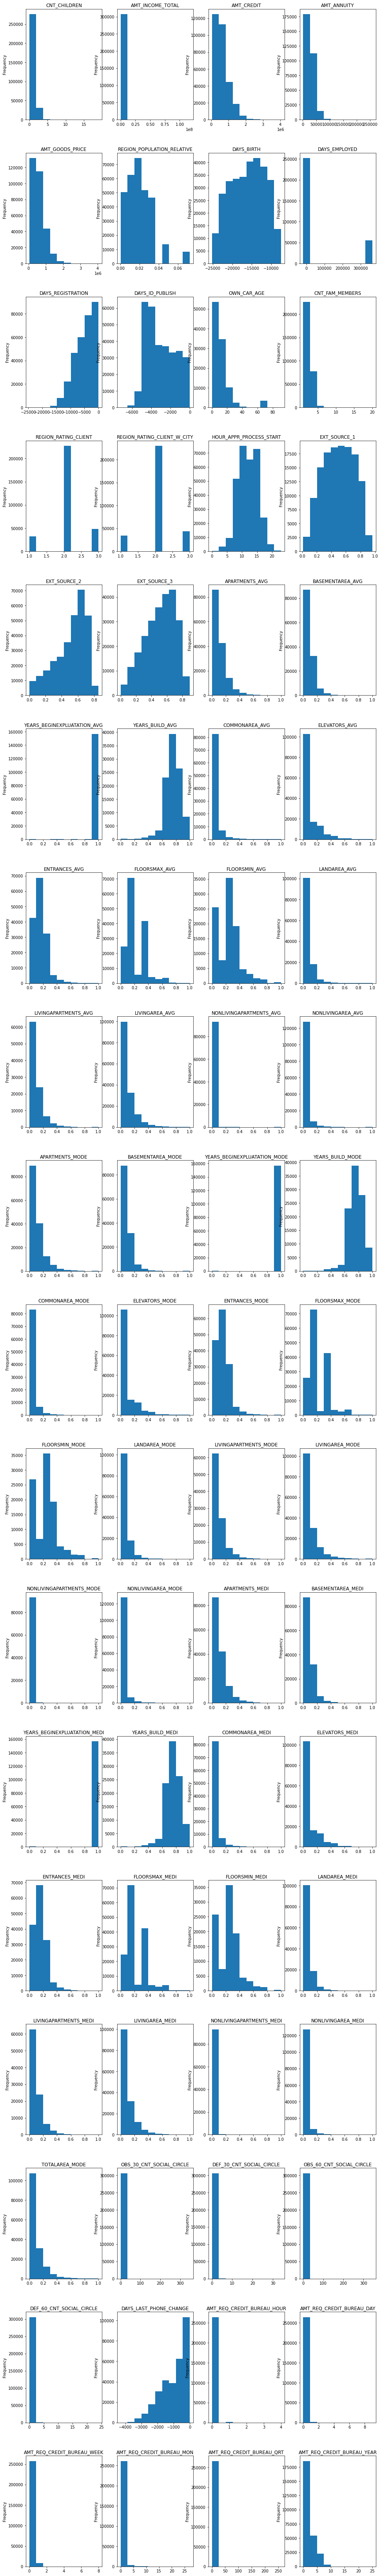

In [63]:
fig, axes = plt.subplots(nrows=18, ncols=4, figsize=(16, 120))
plt.subplots_adjust(hspace=0.3)
axes = axes.flatten()

for i, col in enumerate(num_cols):
    application_train[col].plot(kind="hist", ax=axes[i])
    axes[i].set_title(col)

Some features are very screwed and range over many orders of magnitude such as `AMT_GOODS_PRICE`, `AMT_CREDIT`, `AMT_ANNUITY`, `AMT_INCOME_TOTAL`. May consider log transforming them.

`DAYS_EMPLOYED` are supposed to be negative but there is a very large positive value.

In [64]:
days_emp_max = application_train["DAYS_EMPLOYED"].max()
print("days_emp_max:", days_emp_max)

print("Count of the maximun value:", sum(application_train["DAYS_EMPLOYED"] == days_emp_max))
print("Count of positive values:", sum(application_train["DAYS_EMPLOYED"] > 0))

default_rate_pos = application_train.loc[application_train["DAYS_EMPLOYED"] == days_emp_max, "TARGET"].mean()
print("Default rate for positive DAYS_EMPLOYED: %0.5f" % default_rate_pos)

default_rate_neg = application_train.loc[application_train["DAYS_EMPLOYED"] < days_emp_max, "TARGET"].mean()
print("Default rate for negative DAYS_EMPLOYED: %0.5f" % default_rate_neg)

days_emp_max: 365243
Count of the maximun value: 55374
Count of positive values: 55374
Default rate for positive DAYS_EMPLOYED: 0.05400
Default rate for negative DAYS_EMPLOYED: 0.08660


The difference is quite significant. So we may consider adding a binary column which indicates whether `DAYS_EMPLOYED` is positive. Also we may change the maximum to 1 or `np.nan`.

### Some engineered features

In [65]:
cols = ["AMT_GOODS_PRICE", "AMT_CREDIT", "AMT_ANNUITY", "AMT_INCOME_TOTAL"]
log_transformed_features = application_train[cols]

for col in cols:
    print(col, (log_transformed_features[col] < 0).any())

for col in cols:
    log_transformed_features[col + "_log"] = np.log(log_transformed_features[col] + 1)

corrs = corrwith(log_transformed_features, application_train["TARGET"])
corrs

AMT_GOODS_PRICE False
AMT_CREDIT False
AMT_ANNUITY False
AMT_INCOME_TOTAL False


feature
AMT_GOODS_PRICE        -0.039645
AMT_CREDIT             -0.030369
AMT_GOODS_PRICE_log    -0.022424
AMT_INCOME_TOTAL_log   -0.018482
AMT_ANNUITY            -0.012817
AMT_CREDIT_log         -0.012181
AMT_INCOME_TOTAL       -0.003982
AMT_ANNUITY_log         0.000779
Name: corr, dtype: float64

It looks like only `AMT_INCOME_TOTAL_log` improves the correlation. 

In [66]:
credit_to_income = application_train["AMT_CREDIT"] / application_train["AMT_INCOME_TOTAL"]
credit_to_income.corr(application_train["TARGET"])

-0.007726797153464892

In [67]:
credit_to_goods = application_train["AMT_CREDIT"] / application_train["AMT_GOODS_PRICE"]
credit_to_goods.corr(application_train["TARGET"])

0.06942698687673068

## `bureau`

In [68]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.0,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.0,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.5,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.0,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.0,NaN,NaN,0.0,Consumer credit,-21,NaN


### Missing values

In [69]:
missing_vals = bureau.isnull().mean()
missing_vals = missing_vals.sort_values(ascending=False)
print("Total number of features:", bureau.shape[1])
print("Number of features having missing values:", (missing_vals > 0).sum())

print("head:")
missing_vals.head(10)

Total number of features: 17
Number of features having missing values: 7
head:


AMT_ANNUITY               0.714735
AMT_CREDIT_MAX_OVERDUE    0.655133
DAYS_ENDDATE_FACT         0.369170
AMT_CREDIT_SUM_LIMIT      0.344774
AMT_CREDIT_SUM_DEBT       0.150119
DAYS_CREDIT_ENDDATE       0.061496
AMT_CREDIT_SUM            0.000008
CREDIT_TYPE               0.000000
AMT_CREDIT_SUM_OVERDUE    0.000000
CNT_CREDIT_PROLONG        0.000000
dtype: float64

### Correlation of aggregated features with TARGET

#### Numerical features

In [122]:
by_sers = [bureau["SK_ID_CURR"]]

bureau_num = bureau.drop(["SK_ID_CURR", "SK_ID_BUREAU"], axis="columns")
bureau_num = bureau_num.select_dtypes(["number"])
#bureau_num = bureau_num.fillna(bureau_num.median())

#bureau_num_agg = agg_num_cols(bureau_num, by_sers, ["count", "mean", "median", np.var, "min", "max"])

In [123]:
from sklearn.impute import SimpleImputer

In [124]:
imputer = SimpleImputer(strategy="median")
imputer.fit(bureau_num)

SimpleImputer(strategy='median')

In [125]:
X = imputer.transform(bureau_num)

In [126]:
X

array([[ -497.,     0.,  -153., ...,     0.,  -131.,     0.],
       [ -208.,     0.,  1075., ...,     0.,   -20.,     0.],
       [ -203.,     0.,   528., ...,     0.,   -16.,     0.],
       ...,
       [-1809.,     0., -1628., ...,     0.,  -967.,     0.],
       [-1878.,     0., -1513., ...,     0., -1508.,     0.],
       [ -463.,     0.,  -330., ...,     0.,  -387.,     0.]])

In [111]:
bureau_num_agg.head()

,SK_ID_CURR,DAYS_CREDIT_count,DAYS_CREDIT_mean,DAYS_CREDIT_median,DAYS_CREDIT_var,DAYS_CREDIT_min,DAYS_CREDIT_max,CREDIT_DAY_OVERDUE_count,CREDIT_DAY_OVERDUE_mean,CREDIT_DAY_OVERDUE_median,...,DAYS_CREDIT_UPDATE_median,DAYS_CREDIT_UPDATE_var,DAYS_CREDIT_UPDATE_min,DAYS_CREDIT_UPDATE_max,AMT_ANNUITY_count,AMT_ANNUITY_mean,AMT_ANNUITY_median,AMT_ANNUITY_var,AMT_ANNUITY_min,AMT_ANNUITY_max
0,100001,7,-735.000000,-857.0,240043.666667,-1572,-49,7,0.0,0.0,...,-155.0,5960.476190,-155,-6,7,3545.357178,0.0,23045832.0,0.0,10822.5
1,100002,8,-874.000000,-1042.5,186150.000000,-1437,-103,8,0.0,0.0,...,-402.5,268865.553571,-1185,-7,8,0.000000,0.0,0.0,0.0,0.0
2,100003,4,-1400.750000,-1205.5,827783.583333,-2586,-606,4,0.0,0.0,...,-545.0,824562.000000,-2131,-43,4,0.000000,0.0,0.0,0.0,0.0
3,100004,2,-867.000000,-867.0,421362.000000,-1326,-408,2,0.0,0.0,...,-532.0,45000.000000,-682,-382,2,0.000000,0.0,0.0,0.0,0.0
4,100005,3,-190.666667,-137.0,26340.333333,-373,-62,3,0.0,0.0,...,-31.0,3433.333333,-121,-11,3,1420.500000,0.0,6053461.0,0.0,4261.5


In [121]:
bureau_num_agg_merged = application_train[["SK_ID_CURR", "TARGET"]].merge(
    bureau_num_agg, how="left", on="SK_ID_CURR")

bureau_num_agg = bureau_num_agg.fillna(0)

corr = corrwith(bureau_num_agg_merged.drop(["SK_ID_CURR", "TARGET"], axis="columns"), 
               bureau_num_agg_merged["TARGET"])

corr.head(30)

feature
DAYS_CREDIT_mean               0.089729
DAYS_CREDIT_median             0.085414
DAYS_CREDIT_min                0.075248
DAYS_CREDIT_UPDATE_mean        0.068927
DAYS_CREDIT_UPDATE_median      0.067338
DAYS_ENDDATE_FACT_min          0.055835
DAYS_CREDIT_max                0.049782
DAYS_ENDDATE_FACT_mean         0.045302
DAYS_CREDIT_ENDDATE_mean       0.043613
DAYS_CREDIT_UPDATE_min         0.042864
DAYS_CREDIT_var               -0.038440
DAYS_CREDIT_ENDDATE_max        0.035844
DAYS_CREDIT_ENDDATE_var        0.035322
DAYS_ENDDATE_FACT_var         -0.034876
DAYS_CREDIT_ENDDATE_median     0.034624
DAYS_ENDDATE_FACT_median       0.032842
DAYS_CREDIT_ENDDATE_min        0.031314
DAYS_CREDIT_UPDATE_max         0.028234
AMT_CREDIT_SUM_mean           -0.019956
AMT_CREDIT_SUM_max            -0.019737
AMT_CREDIT_SUM_median         -0.015675
AMT_CREDIT_SUM_LIMIT_mean     -0.010805
AMT_CREDIT_SUM_min            -0.010763
AMT_CREDIT_SUM_OVERDUE_max     0.010614
AMT_CREDIT_SUM_LIMIT_max      -0

#### Categorical features

In [113]:
by_sers = [bureau["SK_ID_CURR"]]

bureau_cat = bureau.drop(["SK_ID_CURR", "SK_ID_BUREAU"], axis="columns")
bureau_cat = bureau_cat.select_dtypes(["category", "bool", "object"])
bureau_cat = bureau_cat.fillna("NULL")

#bureau_num_agg = agg_num_cols(bureau_num, by_sers, ["count", "mean", "median", np.var, "min", "max"])

ValueError: fill value must be in categories